# Calibrate the m16 distances for alignment with camera feed
Note: this notebook differs from v1 since we are exploring data with calibrated camera and lidar.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

First run (front car moving right to left)

In [4]:
data_date = '2018-05-05'
run_number = '0015'
video_file = '/home/robert/PycharmProjects/Einstein/Data/{}/{}.avi'.format(data_date, run_number)
data_file = '/home/robert/PycharmProjects/Einstein/Data/{}/{}.csv'.format(data_date, run_number)
bbox_file = '/home/robert/PycharmProjects/Einstein/Data/Processed/{}/{}.csv'.format(data_date, run_number)
m16_detections1 = pd.read_csv(data_file)
bbox_detections = pd.read_csv(bbox_file)
video_feed1 = cv2.VideoCapture()
video_feed1.open(video_file)

True

In [5]:
m16_detections1.head()

,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,Unnamed: 16
0,13.038803,13.010574,12.974915,12.610672,19.282639,5.254959,19.252518,5.406326,18.991211,5.168549,5.173477,5.382416,28.264969,5.207077,28.276993,0.000000,NaN
1,13.038803,13.010574,12.974915,12.610672,19.282639,5.254959,19.252518,5.406326,18.991211,5.168549,5.173477,5.382416,28.264969,5.207077,28.276993,0.000000,NaN
2,13.038803,13.010574,12.974915,12.610672,19.282639,5.254959,19.252518,5.406326,18.991211,5.168549,5.173477,5.382416,28.264969,5.207077,28.276993,0.000000,NaN
3,13.039322,13.011337,12.975632,12.578979,19.282272,5.351624,19.251694,5.406189,18.994537,5.164337,18.315399,5.173691,5.381454,28.276001,5.203598,28.276993,NaN
4,13.039322,13.011337,12.975632,12.578979,19.282272,5.351624,19.251694,5.406189,18.994537,5.164337,18.315399,5.173691,5.381454,28.276001,5.203598,28.276993,NaN


In [8]:
consolidated = m16_detections1.copy()
consolidated['bboxes'] = bbox_detections['bboxes']

In [10]:
def get_frame(video_feed, frame_num):
    """Get a single frame from video feed"""
    video_feed.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    _ , frame = video_feed.read()
    return frame

# Let's take a look at the sensor readings

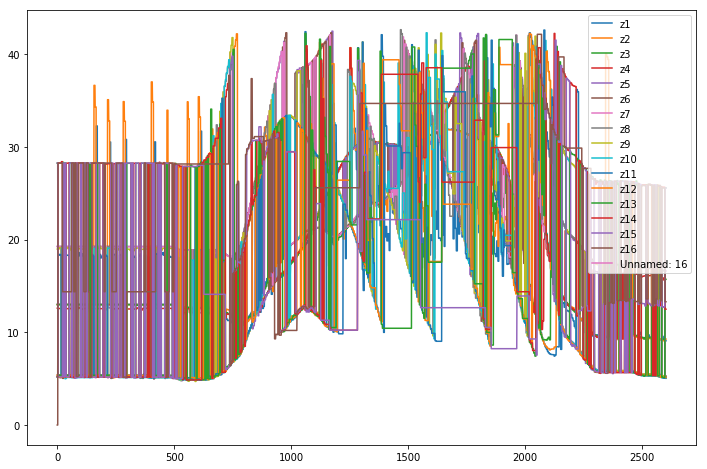

In [11]:
m16_detections1.plot(figsize=(12,8))

## Now take a look at a single sensor

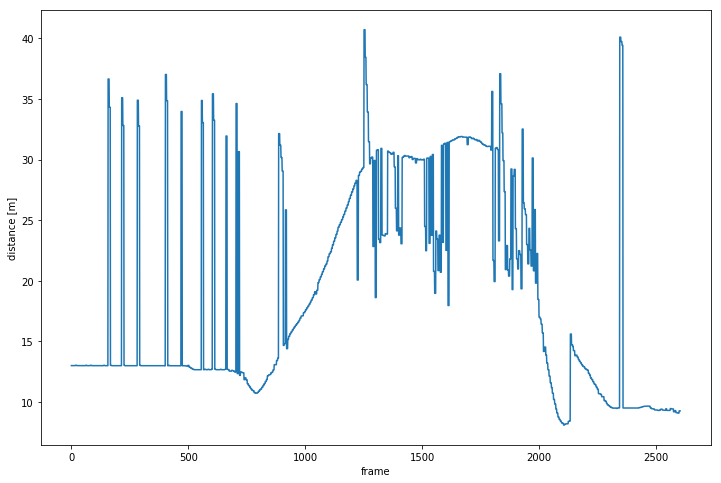

In [20]:
plt.xlabel('frame')
plt.ylabel('distance [m]')
m16_detections1.z2.plot(figsize=(12,8))

Try to smooth out our data.

In [31]:
def despike(yi,th=1.e-8):
    '''Remove spike from array yi, the spike area is where the difference between 
    the neigboring points is higher than th.'''
    y = np.copy(yi) # use y = y1 if it is OK to modify input array
    n = len(y)
    x = np.arange(n)
    c = np.argmax(y)
    d = abs(np.diff(y))
    try:
        l = c - 1 - np.where(d[c-1::-1]<th)[0][0]
        r = c + np.where(d[c:]<th)[0][0] + 1
    except: # no spike, return unaltered array
        return y
    # for fit, use area twice wider then the spike
    if (r-l) <= 3:
        l -= 1
        r += 1
    s = int(round((r-l)/2.))
    lx = l - s
    rx = r + s
    # make a gap at spike area
    xgapped = np.concatenate((x[lx:l],x[r:rx]))
    ygapped = np.concatenate((y[lx:l],y[r:rx]))
    # quadratic fit of the gapped array
    z = np.polyfit(xgapped,ygapped,2)
    p = np.poly1d(z)
    y[l:r] = p(x[l:r])
    return y

In [37]:
def velocity_despike(y, window=1, threshold=10):
    """
    Args:
        y: data to despike
        window: window of velocity values to use during despike
        threshold: velocity threshold in window
    """
    y = y.copy()
    prev = y[0]
    for i in range(1, len(y)):
        abs_vel = abs(prev - y[i])
        if abs_vel > threshold:
            y[i] = prev
        prev = y[i]
    return y
        

/home/robert/venv2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  


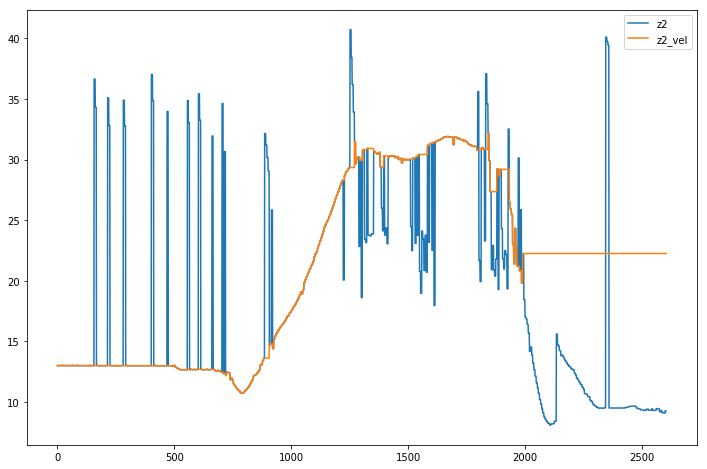

In [42]:
from scipy.interpolate import interp1d
z2_smooth = pd.rolling_mean(m16_detections1.z2, 60)
z2_despike = despike(yi=m16_detections1.z2)
z2_vel = velocity_despike(y=m16_detections1.z2, threshold=3)
m16_detections1['z2_smooth'] = z2_smooth
m16_detections1['z2_despike'] = z2_despike
m16_detections1['z2_vel'] = z2_vel
m16_detections1[['z2','z2_vel']].plot(figsize=(12,8))
# m16_detections1.z2_vel.plot(figsize=(12,8))

We see that between frames ~ 800 to 1000 the car is in view. Let's find out which frames these are and visualize them

In [11]:
segment_frames = m16_detections1.z15[m16_detections1.z15 < 1.5].index # the index corresponds to the frame number
segment_frames

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            175, 176, 177, 178, 179, 180, 181, 182, 183, 184],
           dtype='int64', length=185)

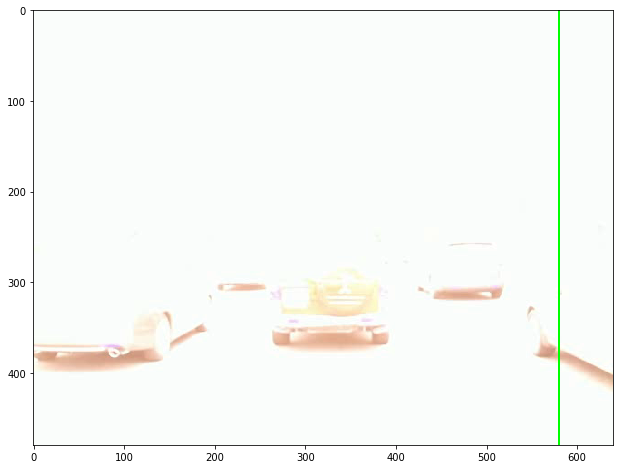

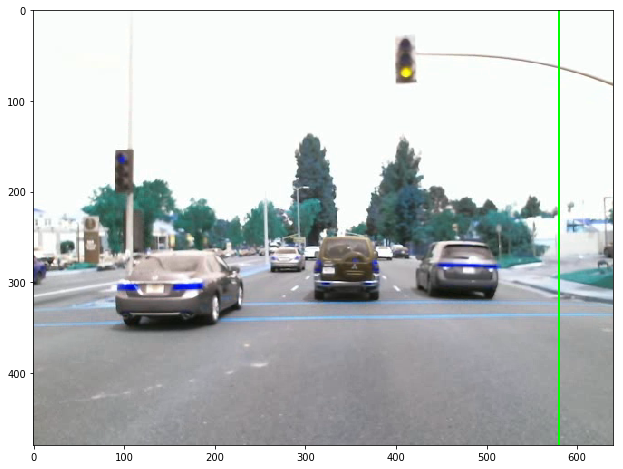

In [12]:
plt.figure(figsize=(12,8))
frame1 = get_frame(video_feed=video_feed1, frame_num=segment_frames.min())
frame2 = get_frame(video_feed=video_feed1, frame_num=segment_frames.max())
# 615
x_val = 580
cv2.line(frame1, (x_val, 0), (x_val, 480), (0,255,0), 2)
cv2.line(frame2, (x_val, 0), (x_val, 480), (0,255,0), 2)
plt.imshow(frame1)
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(frame2)
plt.show()

In [67]:
# draw the detection distances on the video feed

def draw_lidar_spacing_lines(frame, frame_num, lidar_spacing_px=37, start_x_left=90, m16_readings=None):
    end_x_right = start_x_left + 16*lidar_spacing_px
    for seg, x_val in enumerate(range(start_x_left, end_x_right, lidar_spacing_px)):
        cv2.line(frame, (x_val, 0), (x_val, 480), (0,255,0), 2)
#         print(x_val)
        if m16_readings is not None:
            # scale m16 reading btwn 0 and 480
            y_val_m = m16_detections1['z{}'.format(seg + 1)][frame_num]
            min_y_m = 0 # 0 meters as min
            max_y_m = 4 # 4 meters as max
            y_val_normalized = (y_val_m - min_y_m)/(max_y_m - min_y_m)
            y_val_px = int(y_val_normalized * 480)
            center = (x_val, y_val_px)
            cv2.circle(frame, center, 5, (255,0,0), -1)
#             print(x_val)
    return frame

fourcc = cv2.VideoWriter_fourcc(*'XVID')
frame = get_frame(video_feed1, 0)
vw = cv2.VideoWriter('out.avi', fourcc, 20.0, (frame.shape[1], frame.shape[0]))
num_frames = int(video_feed1.get(cv2.CAP_PROP_FRAME_COUNT))

lidar_spacing_px = 38
start_x_left = 615 - lidar_spacing_px*15
for frame_num in range(0, num_frames):
    frame = get_frame(video_feed=video_feed1, frame_num=frame_num)
    frame_draw = draw_lidar_spacing_lines(frame, 
                                          frame_num=frame_num, 
                                          start_x_left=start_x_left, 
                                          lidar_spacing_px=lidar_spacing_px,
                                          m16_readings=m16_detections1)
    vw.write(frame_draw)
#     plt.figure(figsize=(12,8))
#     plt.imshow(frame_draw)
#     plt.show()